# Yêu cầu:
1.download bộ data nhận dạng gương mặt người nổi tiếng từ link: https://drive.google.com/file/d/1kpxjaz3pIMrAhEjm7hJxcBsxKNhfl8t2/view
2. Biến mỗi gương mặt thành embedding sử dụng GhostFaceNet để nhận diện gương mặt

# Using GhostFaceNet - The new SOTA Lightweight Face Recognition

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
from sklearn.preprocessing import normalize
from sklearn.metrics import roc_curve, auc

gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Copy and Extract Data

In [ ]:
!cp /content/drive/MyDrive/LDS8_new_content/b9_face_recognition_p2/data/VN-celeb.zip data.zip
!unzip data.zip

Streaming output truncated to the last 5000 lines.
  inflating: VN-celeb/100/15.png     
  inflating: VN-celeb/100/16.png     
  inflating: VN-celeb/100/17.png     
  inflating: VN-celeb/100/18.png     
  inflating: VN-celeb/100/19.png     
   creating: VN-celeb/340/
  inflating: VN-celeb/340/0.png      
  inflating: VN-celeb/340/1.png      
 extracting: VN-celeb/340/2.png      
  inflating: VN-celeb/340/3.png      
 extracting: VN-celeb/340/4.png      
   creating: VN-celeb/825/
  inflating: VN-celeb/825/0.png      
  inflating: VN-celeb/825/1.png      
 extracting: VN-celeb/825/2.png      
 extracting: VN-celeb/825/3.png      
  inflating: VN-celeb/825/4.png      
  inflating: VN-celeb/825/5.png      
  inflating: VN-celeb/825/6.png      
 extracting: VN-celeb/825/7.png      
  inflating: VN-celeb/825/8.png      
  inflating: VN-celeb/825/9.png      
 extracting: VN-celeb/825/10.png     
  inflating: VN-celeb/825/11.png     
  inflating: VN-celeb/825/12.png     
  inflating: VN-celeb

# 1. Giải thích Eval_Image Class:
## 1.1. Hàm init:

model_interf : là model hoặc file checkpoint lưu model và weight.


```
 self.model_interf = lambda imms: model((imms - 127.5) * 0.0078125).numpy()
```
=> Chuẩn hoá input đầu vào

img_path: thư mục chứa folder của các ảnh gương mặt

output_dir: path lưu file embeddings của tập dataset hiện tại

## 1.2 Hàm prepare_image_and_embedding:

Có nhiệm vụ lưu mỗi hình ảnh trong dataset thành 1 vector embedding

Dataset có 4720 hình ảnh => lưu 4720 vector embedding vào 1 file .npz.

Ngoài ra file npz này còn lưu thêm thông tin tên các ảnh, và nhãn (identity) của từng ảnh

## 1.3. Hàm do_evaluationn:

Tính độ chính xác của model (accuracy) và, trả về:

labels: tất cả dự đoán của model, ở dạng 1 và 0. Positive prediction (=1) nghĩa là model dự đoán ảnh này thuộc identity đó, ngược lại là 0.

scores: similary (điểm số của model) khi đưa ra các quyết định như trên

=> labels và scores sẽ dùng để vẽ auc-roc curve


In [ ]:
class Eval_image:
    def __init__(self, model_interf, img_path, output_dir,root_img_path):

        if isinstance(model_interf, str) and model_interf.endswith("h5"):
            model = tf.keras.models.load_model(model_interf)
            self.model_interf = lambda imms: model((imms - 127.5) * 0.0078125).numpy()
        else:
            self.model_interf = model_interf
        self.dist_func = lambda aa, bb: np.dot(aa, bb) # hàm tính khoảng cách giữa 2 vector
        self.output_dir = output_dir
        self.img_path = img_path
        print('begin serving')
        self.root_path = root_img_path
        self.embs, self.imm_classes, self.filenames = self.prepare_image_and_embedding(self.img_path, self.output_dir)

    def prepare_image_and_embedding(self, img_folder, output_dir):
        save_embeddings = output_dir
        # kiểm tra đường dẫn, nếu đã lưu các embedding vector vào file npz thì chỉ load lại
        if save_embeddings and os.path.exists(save_embeddings):
            print(">>>> Reloading from backup:", save_embeddings)
            aa = np.load(save_embeddings)
            embs, imm_classes, filename = aa["embs"], aa["imm_classes"], aa["filenames"]
            emb, img_class = embs.astype("float32"), imm_classes.astype("int")
        else:
            # chưa lưu => đọc mỗi hình
            img_shape = (112, 112)
            imgs = pd.read_csv('./train.csv')['image'].tolist() # danh sách tên các hình
            labels = pd.read_csv('./train.csv')['label'].tolist() # danh sách label của các hình
            embs = [] # list of embeddings
            classes = [] # list nhãn của mỗi hình (mỗi vector embedding)
            names = [] # list lưu tên file của mỗi hình
            for i,img_path in enumerate(tqdm(imgs)):
                img_path = os.path.join(self.root_path,img_path) # đọc file từng ảnh
                img = cv2.imread(img_path)
                img = cv2.resize(img, img_shape, interpolation=cv2.INTER_AREA)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = np.expand_dims(img, axis=0) # biến ảnh về kích thước (1,112,112,3)

                emb = self.model_interf(img) # lưu vector embedding
                emb = normalize(np.array(emb).astype("float32"))[0] # chuẩn hoá 1 vector theo L2 norm
                img_class = int(labels[i]) # nhãn của ảnh hiện tại
                classes.append(img_class) # lưu nhãn của ảnh hiện tại
                embs.append(emb) # lưu vector embedding của ảnh hiện tại
                filename = os.path.basename(img_path) # lấy filename (dạng abc.xyz)
                names.append(filename) # lưu filename của ảnh hiện tại
            # lưu tất cả thông tin trên vào 1 file npy
            np.savez(output_dir, embs=embs, imm_classes=classes, filenames=names)

        return np.array(embs), np.array(classes), np.array(names)


    def do_evaluation(self):
        register_ids = np.unique(self.imm_classes) ## đếm xem có bao nhiêu identity trong dataset aka có bao nhiêu người có mặt trong dataset :D
        print(">>>> [base info] embs:", self.embs.shape, "imm_classes:", self.imm_classes.shape, "register_ids:", register_ids.shape)

        register_base_embs = np.array([]).reshape(0, self.embs.shape[-1]) # lưu vector đại diện của từng gương mặt
        register_base_dists = []
        for register_id in tqdm(register_ids, "Evaluating"):
            # với từng identity: tìm các hình chứa gương mặt của người đó
            pos_pick_cond = self.imm_classes == register_id
            # lấy vector của các gương mặt đó
            pos_embs = self.embs[pos_pick_cond]
            # tạo ra vector đại diện cho identity đó : sum các vector gương mặt, sau đó normalize
            register_base_emb = normalize([np.sum(pos_embs, 0)])[0]
            # tính similarity của vector đại diện tới toàn bộ vector trong dataset
            register_base_dist = self.dist_func(self.embs, register_base_emb)
            register_base_dists.append(register_base_dist) # lưu kết quả vào 1 list
            register_base_embs = np.vstack([register_base_embs, register_base_emb])
        register_base_dists = np.array(register_base_dists).T # similarity (cosine similarity) của toàn bộ identity tới toàn bộ vector trong dataset
        # cosine similarity from one image to each class
        print(register_base_dists.shape) # như vậy nó có shape 4720x1000

        # đồng thời theo chiều ngược lại : 1 ảnh (trong 4720 ảnh trong dataset), sẽ dc tính độ tương tự với 1000 vector đại diện
        ### bắt đầu quá trình tính toán accuracy

        # register_base_dists.argmax(1) => tìm identity tương tự nhất cho mỗi ảnh
        # accuracy = số lượng ảnh mà model detect identity đúng / số lượng ảnh (4720)
        accuracy = (register_base_dists.argmax(1) == self.imm_classes).sum() / register_base_dists.shape[0]
        print("register_ids shape: ",register_ids.shape)
        print("self.imm_classes shape: ",self.imm_classes.shape)

        # tạo 1 array có 4720 dòng x 1000 cột => mỗi dòng là 1 hình, hình dc predict có identity nào thì giá trị cột đó =1
        reg_pos_cond = np.equal(register_ids, np.expand_dims(self.imm_classes, 1))
        print(reg_pos_cond.shape) # array co 1 nghin cot, gia tri tai cot label =1

        # tính similarity của hình đó với vector identity gần nhất (positive prediction)
        reg_pos_dists = register_base_dists[reg_pos_cond].ravel()
        print(reg_pos_dists.shape) # 4720
        # similarity của các hình với các 999 vector identity xa hơn (999 negative prediction)
        reg_neg_dists = register_base_dists[np.logical_not(reg_pos_cond)].ravel()
        print(reg_neg_dists.shape) # 4720*999
        # turn it into a binary classification
        # label: tất cả prediction của model (positive hay negative) đều dc flatten
        # score: similarity tương ứng của model cho các quyết định đó
        label = np.concatenate([np.ones_like(reg_pos_dists), np.zeros_like(reg_neg_dists)])
        score = np.concatenate([reg_pos_dists, reg_neg_dists]) #distance tai cot co label va k co label
        return accuracy,score,label

def plot_tpr_far(score, label, new_figure=True, label_prefix=""):
    fpr, tpr, _ = roc_curve(label, score)
    roc_auc = auc(fpr, tpr)

    fpr_show = [10 ** (-ii) for ii in range(1, 7)[::-1]]
    fpr_reverse, tpr_reverse = fpr[::-1], tpr[::-1]
    tpr_show = [tpr_reverse[np.argmin(abs(fpr_reverse - ii))] for ii in fpr_show]
    print(pd.DataFrame({"FPR": fpr_show, "TPR": tpr_show}).set_index("FPR").T.to_markdown())

    try:
        import matplotlib.pyplot as plt

        fig = plt.figure() if new_figure else None
        label = "AUC = %0.4f%%" % (roc_auc * 100)
        if label_prefix and len(label_prefix) > 0:
            label = label_prefix + " " + label
        plt.plot(fpr, tpr, lw=1, label=label)
        plt.xlim([10 ** -6, 0.1])
        plt.xscale("log")
        plt.xticks(fpr_show)
        plt.xlabel("False Positive Rate")
        plt.ylim([0, 1.0])
        plt.yticks(np.linspace(0, 1.0, 8, endpoint=True))
        plt.ylabel("True Positive Rate")

        plt.grid(linestyle="--", linewidth=1)
        plt.title("ROC")
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.show()
    except:
        print("matplotlib plot failed")
        fig = None
    return fig

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.getcwd()

'/content'

In [ ]:
demo_image = Eval_image("/content/drive/MyDrive/LDS8_new_content/b9_face_recognition_p2/data/GhostFaceNet_W1.3_S1_ArcFace.h5", "./VN-celeb", output_dir="/content/drive/MyDrive/LDS8_new_content/b9_face_recognition_p2/data/root_embs/vn2.npz",root_img_path="/content/VN-celeb")

begin serving
>>>> Reloading from backup: /content/drive/MyDrive/LDS8_new_content/b9_face_recognition_p2/data/root_embs/vn2.npz


In [ ]:
accuracy, score, label = demo_image.do_evaluation()

>>>> [base info] embs: (4720, 512) imm_classes: (4720,) register_ids: (1000,)


Evaluating: 100%|██████████| 1000/1000 [00:04<00:00, 246.78it/s]


(4720, 1000)
register_ids shape:  (1000,)
self.imm_classes shape:  (4720,)
(4720, 1000)
(4720,)
(4715280,)


In [ ]:
accuracy

0.9330508474576271

|     |    1e-06 |    1e-05 |   0.0001 |    0.001 |    0.01 |      0.1 |
|:----|---------:|---------:|---------:|---------:|--------:|---------:|
| TPR | 0.500212 | 0.686017 | 0.841314 | 0.935593 | 0.98178 | 0.998517 |


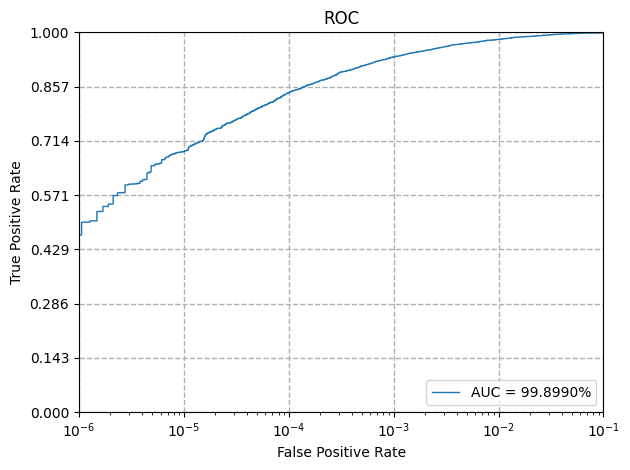

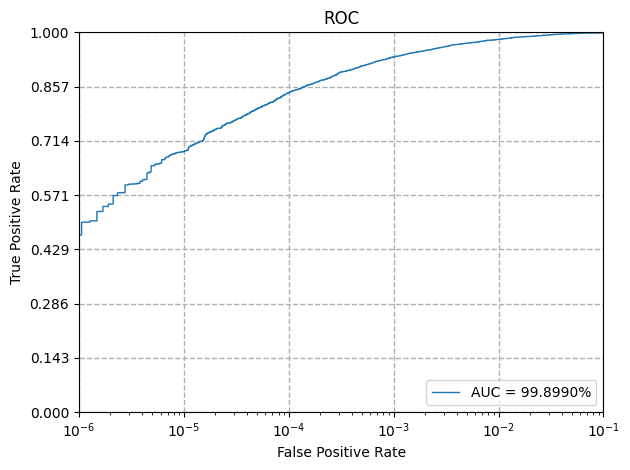

In [ ]:
plot_tpr_far(score, label, new_figure=True, label_prefix="")